# How Bad Can the Confidence Interval Be
### Fred J. Hickernell

This demo makes use of our QMCPy software package.  See [qmcpy.org](www.qmcpy.org) for more details.

### Some LaTeX macros (hidden in math mode)
$
\newcommand{\vh}{\boldsymbol{h}}
\newcommand{\vt}{\boldsymbol{t}}
\newcommand{\vx}{\boldsymbol{x}}
\newcommand{\vX}{\boldsymbol{X}}
\newcommand{\cf}{\mathcal{F}}
\newcommand{\cu}{\mathcal{U}}
\newcommand{\dif}{\mathrm{d}}
\newcommand{\Ex}{\mathbb{E}}
\newcommand{\Pr}{\mathbb{P}}
\newcommand{\Order}{\mathcal{O}}
\newcommand{\hmu}{\hat{\mu}}
\DeclareMathOperator{\disc}{disc}
\newcommand{\norm}[2][{}]{{\left \lVert #2 \right \rVert}_{#1}}
$

#### If are running this notebook in on colab, replace False in the next cell by True

In [2]:
if False:  #Running on colab?
    !sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
    !sudo apt install cm-super
    !pip install git+https://github.com/QMCSoftware/QMCSoftware.git@MCQMC2024

### Import needed packages

In [3]:
import matplotlib.pyplot as plt
#import matplotlib.patches as patches
#from matplotlib import cm
#import math
import numpy as np
import scipy as sp
from scipy.stats import binom
import time
import timeit
import pickle
import sys
np.seterr(divide='raise', invalid='raise') #check for divide by zeros

#These are parameters needed for figures
figpath = 'HowBadCanCIBeFigures/' #this path sends the figures to the directory that you want
savefigs = True  #save the figures on your disk if True
imgfrmt = 'pdf' #kind of format to save figures as
long_compute = True #redo the long computations
font_family = "serif"
plt.rcParams.update({
    "font.family" : font_family,
    "text.usetex" : True,  
    "mathtext.fontset" : "dejavuserif",
    "axes.labelsize" : 18,
    "axes.titlesize" : 18,
    "xtick.labelsize" : 14,
    "ytick.labelsize" : 14
})

In [4]:
import matplotlib.colors as mcolors
# for plotting, here are our different symbols and their colors
# because plots may be printed in black and white we want different colors to have different marker shapes 
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']  #get the color cycle


## Bernoulli Example

$$
\Pr(Y = 1)  = p, \quad \Pr(Y = 0) = 1- p, \qquad 0 \le p \le 1
$$
If $Y_1, Y_2, \ldots$ are IID, then the $S_n = Y_1 + \cdots + Y_n \sim \text{Binomial}(n,p)$, and the sample mean is $\hmu_n = S_n/n$.

### Function to compute the mean of the Bernoulli random variable
A successful $1 - \alpha$ confidence interval for $\mu = p$ must satisfy

\begin{align*}
1 - \alpha \le \Pr(\hmu_n - \varepsilon \le \mu \le \hmu_n + \varepsilon) 
& \Longleftrightarrow 1 - \alpha \le \Pr(S_n - n\varepsilon \le n\mu \le S_n + \varepsilon) \\
& \Longleftarrow \Pr(S_n \le n\mu - n\varepsilon ) < \alpha/2 \ \& \ \Pr(S_n \ge n\mu + n \varepsilon) < \alpha/2 \\
& \Longleftarrow n\mu - n\varepsilon \le F^{-1}(\alpha/2) \ \& \ n\mu + n \varepsilon \ge F^{-1}(1-\alpha/2) \\
& \Longleftrightarrow \varepsilon \ge \mu - F^{-1}(\alpha/2)/n \ \& \ \varepsilon \ge F^{-1}(1-\alpha/2)/n - \mu \\
\end{align*}

On the other hand, a CLT confidence interval will have width
$$
-2\Phi^{-1}(\alpha)\sqrt{p(1-p)},
$$
where $\Phi$ is the cumulative distribution function of the Gaussian distribution

In [6]:
print(sp.stats.norm.ppf(0.05/2))

-1.9599639845400545


In [14]:
def ci_bernoulli_best(n = 100, p = 0.1, alpha = 0.05):
    success = sp.stats.binom(n,p)  #number of successes = sum of n 
    width = np.max([p - success.ppf(alpha/2)/n,success.ppf(1-alpha/2)/n - p])
    return width

def ci_bernoulli_CLT(n = 100, p = 0.1, alpha = 0.05):
    width = -2*np.sqrt(p*(1-p))*sp.stats.norm.ppf(alpha/2)/np.sqrt(n)
    return width

In [16]:
alpha = 0.05
width= ci_bernoulli_best(100,1/10000,alpha)
print(f"width of confidence {(1-alpha)*100}% interval = {width}")

width of confidence 95.0% interval = 0.0001


### Computing the possible widths of confidence intervals
We let $p =n^{-q}$ for various values of $q$.  We expect that the widths of the confidence intervals can decrease like the maximum of 
$$
\Order(\text{std}(Y)/\sqrt{n}) = \Order(\sqrt{p}/\sqrt{n}) = \Order(n^{-(q+1)/2})  
\qquad 
\text{and}
\qquad
\Order(n^{-1}).
$$ 
For $q < 1$ the first is the limiting factor and for  $q > 1$ the second is the limiting factor

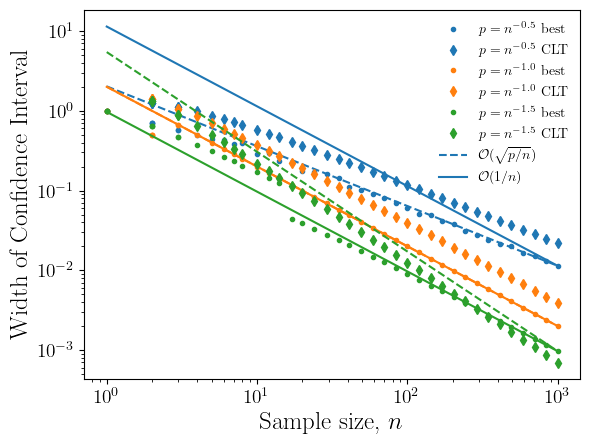

In [20]:
nvec = np.round(np.geomspace(1,1000,40))
power_vec = np.array([-0.5,-1,-1.5])
#print(nvec)
width_best = np.zeros_like(nvec)
width_CLT = np.zeros_like(nvec)
fig,ax = plt.subplots(1)
for jj, power in enumerate(power_vec):
    pvec = nvec**power_vec[jj]
    for ii, n in enumerate(nvec):
        p = pvec[ii]
        width_best[ii] = ci_bernoulli_best(n,p)
        width_CLT[ii] = ci_bernoulli_CLT(n,p)
    #print(width)
    ax.loglog(nvec,width_best,'.', color = color_cycle[jj], label = f"$p = n^{{{power_vec[jj]}}}$ best")
    ax.loglog(nvec,width_CLT,'d', color = color_cycle[jj], ms = 5, label = f"$p = n^{{{power_vec[jj]}}}$ CLT")
    if jj == 0:
        ax.loglog(nvec[[1,-1]],width_best[-1]*np.array([nvec[-1]/nvec[1],1]),'-',color = color_cycle[jj], \
                  label = f"$\mathcal{{O}}(1/n)$")
        ax.loglog(nvec[[1,-1]],width_best[-1]*np.array([np.sqrt(pvec[1]/pvec[-1]),1])*[np.sqrt(nvec[-1]/nvec[1]),1],'--',color = color_cycle[jj], \
                  label = f"$\mathcal{{O}}(\sqrt{{p/n}})$")
    else:
        ax.loglog(nvec[[1,-1]],width_best[-1]*np.array([nvec[-1]/nvec[1],1]),'-',color = color_cycle[jj])
        ax.loglog(nvec[[1,-1]],width_best[-1]*np.array([np.sqrt(pvec[1]/pvec[-1]),1])*[np.sqrt(nvec[-1]/nvec[1]),1],'--',color = color_cycle[jj])
ax.set_xlabel("Sample size, $n$")
ax.set_ylabel("Width of Confidence Interval")

handles, labels = plt.gca().get_legend_handles_labels()  # Get handles and labels
new_order = [0, 1, 4, 5, 6, 7, 3, 2]  # Specify the new order
plt.legend([handles[i] for i in new_order], [labels[i] for i in new_order], frameon = False); #Add legend with the new order

Note that for $p = n^{-1/2}$, the width of the best confidence interval decays like $\Order)\sqrt{p/n})$, whereas for $p = n^{-3/2}$, the width of the best confidence interval decays like $\Order(1/n)$